imports

In [1]:
''' imports '''

import numpy as np
import pandas as pd

from scipy.interpolate import splrep, splev
from scipy.signal import savgol_filter
import os, re, logging

%matplotlib widget
#import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import matplotlib.colors as colors
import matplotlib.cm as cmx

from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize

import pickle, random

# density clustering using HDBSCAN* algorithm
#import hdbscan

# dimensionality reduction using UMAP
#import umap

''' torch imports '''

import torch, math

from torch import nn
from torch import optim
from torch.distributions import Normal

#import torchsde, torchcde



''' init shjnn dev env '''

# set auto reload imported modules
%load_ext autoreload
%autoreload 2

# add location to path
import sys
sys.path.append('../libs/')

import shjnn


dataloader

In [2]:
## load raw data from file

# open binary file for reading
with open('{}/{}'.format('../run/', 'raw-full'), 'rb') as file:

    # load pickled data storage array
    db = pickle.load(file)


## parameter mappings to dimension data

val_map = {
    # sample id to thickness in nm
    'thickness': {'source': 'sample',
                  '12': 160, '16': 160, '21': 160, '33': 160, '45': 160, '58': 160, },
    # intensity in uJ
    'intensity': {'source': 'int',
                  'dark': 0., '32uJ': 32., '10uJ': 10., '3uJ': 3., '1uJ': 1., '03uJ': .3},
    # voltage in V
    'voltage': {'source': 'vlt',
                '05V': .5, '0V': 0., '15V': 1.5, '1V': 1., '2V': 2.},
    # delay time in log10(s)
    'delay': {'source': 'del',
              '100ns': 1e-7, '100us': 1e-4, '10ms': 1e-2, '10us': 1e-5, '1ms': 1e-3, '1us': 1e-6,
              '200ns': 2e-7, '200us': 2e-4, '20ms': 2e-2, '20us': 2e-5, '2ms': 2e-3, '2us': 2e-6,
              '500ns': 5e-7, '500us': 5e-4, '50ms': 5e-2, '50us': 5e-5, '5ms': 5e-3, '5us': 5e-6,
             },
}

''' generate properties data '''

# iterate nodes in database
for node in db[:]:
    
    props = {}
    
    # iterate value mapping
    for key, value in val_map.items():
    
        # check node params for value
        if value['source'] in node['params'].keys():
            
            # map param to prop value
            props[key] = value[ node['params'][ value['source'] ] ]
                        
        else:
            # store zero for no match
            props[key] = 0.
            
    # store props in node
    node['props'] = props
''' generate properties data '''

# iterate nodes in database
for node in db[:]:
    
    props = {}
    
    # iterate value mapping
    for key, value in val_map.items():
    
        # check node params for value
        if value['source'] in node['params'].keys():
            
            # map param to prop value
            props[key] = value[ node['params'][ value['source'] ] ]
                        
        else:
            # store zero for no match
            props[key] = 0.
            
    # store props in node
    node['props'] = props

''' compile lists params '''

# compile list samples
smpls = sorted(list(set([ _['params']['sample'] for _ in db ])))
print( 'smpls', smpls )

# compile list voltages
vlts = sorted(list(set([ _['props']['voltage'] for _ in db ])))
print( 'vlts', vlts )

# compile list voltages
ints = sorted(list(set([ _['props']['intensity'] for _ in db ])))
print( 'ints', ints )

# complete list delays
#dels = sorted(list(set([ _['props']['delay'] for _ in db ])))[1::]
# restricted delay set
dels = sorted(list(set([ _['props']['delay'] for _ in db ])))[1::3]
print( 'dels', dels )


smpls ['12', '16', '21', '33', '45', '58']
vlts [0.0, 0.5, 1.0, 1.5, 2.0]
ints [0.0, 0.3, 1.0, 3.0, 10.0, 32.0]
dels [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01]


150


KeyboardInterrupt: 

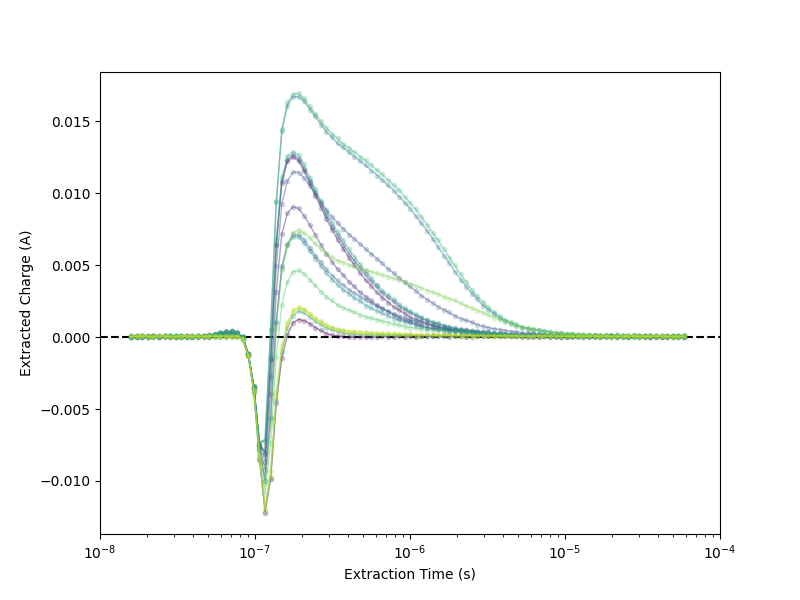

: 

In [3]:

''' get full single-sample dataset '''

# select transient conditions
_smpl = '33'
#_int = '10uJ'
#_vlt = '15V'
#_del = '10us'

_db = [ n for n in db if
       n['params']['sample'] == _smpl and
       n['props']['delay'] != 0.
       #n['params']['int'] == _int and
       #n['params']['vlt'] == _vlt and
       #n['params']['del'] == _del
      ]

print(len(_db))


# initialise figure
fig = plt.figure(figsize = (8,6))
#axs = [[ fig.add_subplot(v,h,i+1) for i in range(h*v) ] for h,v in [(2,1)]][0]
axs = [[ fig.add_subplot(v,h,i+1) for i in range(h*v) ] for h,v in [(1,1)]][0]

# colourmap
cnorm  = colors.Normalize(vmin = 0, vmax = len(_db[::10])); smap = cmx.ScalarMappable(norm = cnorm, cmap = 'viridis')

# zero baseline
axs[0].plot([1e-8, 1e-4], [0,0], '--k')


for i, n in enumerate(_db[::10]):
    
    # get time axis
    t = n['data'][:,0]
    d = n['data'][:,1]/50.
    #d0 = dark0['data'][:,1]#/50.
    #ds = d-d0

    c = smap.to_rgba(i)

    #print(light['params']['del'])

    #np.power(10,val_map['delay'][light['params']['del']])
    #sub = np.vstack([dark[:,0], (light[:,1] - dark[:,1])/50. ]).T

    #l = light['data'][:,1]#/50.
    #s = l-d

    # calculate current transient, illuminated less dark transient, voltage over 50 Ohm res
    #a = (light[:,1] - dark[:,1])/50.

    # smooth and calculate derivatives
    a = savgol_filter(x = d, window_length = 5, polyorder = 1, deriv = 0)

    _ds = 10
    
    # plot data
    axs[0].plot(t[::_ds], d[::_ds], '.', alpha = 0.2, color = c, linewidth = 2)
    axs[0].plot(t[::_ds], a[::_ds], '-', alpha = 0.44, color = c, linewidth = 1, label = ''.format())


    #axs[1].plot(t, da, '-', alpha = 0.7, color = c, linewidth = 1, label = '{}'.format(light['params']['int']))

        
# format plots
for i in range(len(axs)):
    axs[i].set_xscale('log')
    axs[i].set_xlim(1.0e-8, 1.0e-4)
    #axs[i].set_xlim(2.0e-7, 1.0e-4)
    
    #axs[i].set_ylim(0., 1.0e-2)
    axs[i].set_xlabel('Extraction Time (s)')
    axs[i].set_ylabel('Extracted Charge (A)')
    #axs[i].legend(title='Illumination')
    
plt.tight_layout()
plt.show()

# d45-0V-100ns-intensity 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
device

device(type='cuda')

In [ ]:
''' prepare training dataset '''

''' get full single-sample dataset '''

# select transient conditions
_smpl = '33'
#_int = '10uJ'
#_vlt = '15V'
#_del = '10us'

_db = [ n for n in db if
       n['params']['sample'] == _smpl and
       n['props']['delay'] != 0.
       #n['params']['int'] == _int and
       #n['params']['vlt'] == _vlt and
       #n['params']['del'] == _del
      ]
 
j = np.where(_db[0]['data'][:,0] > 1e-9)[0]

# get log time steps, shift decay start to zero
#ts = np.log10(db[0]['data'][:,0][::_ds])
ts = np.transpose( np.stack([ [ 
    #n['data'][:,0][::_ds], # time
    #n['data'][j,0][::_ds]
    
    np.log10(n['data'][j,0][::_ds])+6.7,
  ]
 #for n in _db ]), (2,0,1))
    for n in _db ]), (0,2,1))


# stack raw data and env vars, time first
#d = np.transpose( np.stack([ [ n['data'][:,1][::_ds], 
d = np.transpose( np.stack([ [ 
    #np.log10(n['data'][j,0][::_ds]), # time
    
    n['data'][j,1][::_ds]*1e2, # response, scale to ~one
    #np.log10(n['data'][j,0][::_ds])+6.6,
    
   #np.ones(len(ts))* np.log10(n['props']['intensity']),
   #np.ones(len(ts))* n['props']['voltage']/10,
   #np.ones(len(ts))* np.abs(np.log10(n['props']['delay']))/10,
  ]
 #for n in _db ]), (2,0,1))
    for n in _db ]), (0,2,1))

print(ts.shape, d.shape)

''' compile env. labels '''

# stack raw data and env vars, time first
y = np.stack([ [ 
   n['props']['intensity'],
   n['props']['voltage'],
   n['props']['delay'],
  ]
    for n in _db ])

y.shape

# compile trajectories, time as tensors, push to device
trajs = torch.Tensor(d).to(device)
times = torch.Tensor(ts).to(device)

print(len(d), d[0].shape, ts[0].shape)

trajs[0][::5]

(150, 100, 1) (150, 100, 1)
150 (100, 1) (100, 1)


tensor([[ 1.6873e-01],
        [ 1.8759e-01],
        [ 2.5004e-01],
        [ 4.9361e-01],
        [-8.1636e-01],
        [-4.9469e+01],
        [ 6.0837e+00],
        [ 1.1846e+00],
        [ 2.2393e-02],
        [ 2.8215e-01],
        [ 2.5958e-01],
        [ 3.1573e-01],
        [ 1.0027e-01],
        [ 2.6653e-01],
        [ 1.1035e-01],
        [ 1.1741e-01],
        [ 2.4919e-01],
        [ 3.4536e-01],
        [ 2.3769e-01],
        [ 1.3074e-01]], device='cuda:0')

model initialization layer

In [ ]:
''' init model '''

# set model and training configs
latent_dim = 8
nhidden = 128
rnn_nhidden = 32

obs_dim = trajs[0].size()[1]

#lr = 3e-5
#lr = 1e-4
lr = 1e-3
n_batch = 16
beta = .001

# initialise models and optimser
func, rec, dec, optim, device = shjnn.init_model(latent_dim, nhidden, rnn_nhidden, obs_dim, n_batch, lr, device = 'cpu')
#func, rec, dec, optim, device = shjnn.init_model(latent_dim, nhidden, rnn_nhidden, obs_dim, n_batch, lr, device = device)

loss: list = []
epochs = 0

rec
func
dec

intialising model on device: cuda


Decoder(
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

run training loop

In [ ]:
''' run training loop with save '''

n_epochs = 500

# beta for beta latent dissentanglement
#beta = 4.
beta = .01

# update learning rate
lr = 1e-3
for g in optim.param_groups:
    g['lr'] = lr


# run training for epochs, return loss
_epochs, _loss = shjnn.train(func, rec, dec, optim, trajs[:], times[:], n_epochs, n_batch, device, beta)

# update loss, epochs
loss += _loss
epochs += _epochs

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

pos-train

plot training

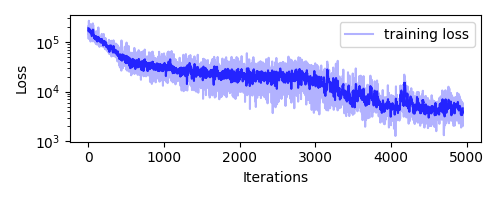

In [ ]:
''' plot training loss '''

# initialise figure
k = 1; _w = 5; _h = 2*k; fig = plt.figure(figsize = (_w, _h))
#fig.canvas.layout.width = '{}in'.format(_w); fig.canvas.layout.height= '{}in'.format(_h)
ax = [ [ fig.add_subplot(j,1,i) for i in range(1,j+1) ] for j in [k] ][0]


# plot original and predicted trajectories
ax[0].plot([_+1e1 for _ in loss], '-b', label = 'training loss', alpha = 0.3)

# smooth loss
train_loss = np.abs( savgol_filter(loss, 13, 3) )

# plot original and predicted trajectories
ax[0].plot([_+1e1 for _ in train_loss], '-b', alpha = 0.8)


# format and display figure
plt.yscale('log')
#plt.xscale('log')

plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.legend()
plt.tight_layout()
plt.show()

assess fit

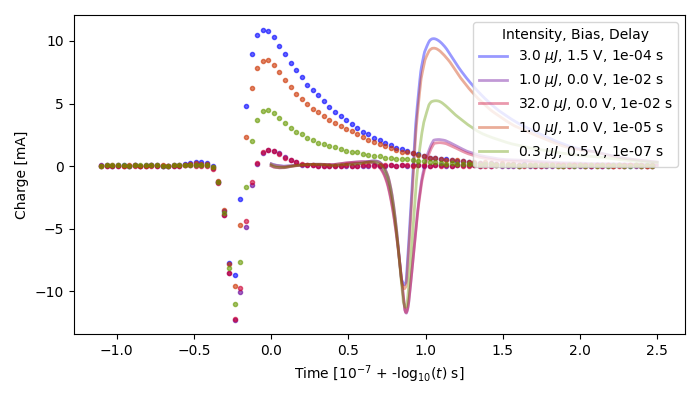

In [ ]:
''' random assess model fit '''

# initialise figure
k = trajs[0].shape[-1]; _w = 7; _h = 4*k; fig = plt.figure(figsize = (_w, _h))
#fig.canvas.layout.width = '{}in'.format(_w); fig.canvas.layout.height= '{}in'.format(_h)
ax = [ [ fig.add_subplot(j,1,i) for i in range(1,j+1) ] for j in [k] ][0]

# generate inference function
infer_step = shjnn.make_infer_step(func, rec, dec, optim, device, _input = 'traj', _sample=False)

# select data
j = list(range(len(trajs)))
random.shuffle(j)

# downsample
j = j[::30]

# build colourmap
cnorm  = colors.Normalize(vmin = 0, vmax = len(j)); smap = cmx.ScalarMappable(norm = cnorm, cmap = 'brg')

# iterate over transients
for _,i in enumerate(j):
    
    # get colour
    c = smap.to_rgba(_)
    
    # send mini-batch to device
    traj = trajs[i].view(1, *trajs[i].size()).to(device)
    
    #_time = np.linspace(-7.8, -4.2, 1000)#/10
    #_time = np.linspace(-6.5+6.6, -4.2+6.6, 1000)#/10
    
    _time = np.linspace(0, 2.5, 1000)#/10
    
    #_time = np.linspace(-7., -4.2, 1000)
    #_time = np.logspace(-7.8, -4.2, 1000)
    
    #_time = np.logspace(0, 1.7, 20)
    time = torch.Tensor(_time).to(device)

    # perform inference step for prediciton
    pred_x, pred_z = infer_step(traj, time)

    # return prediction to cpu
    pred_x = pred_x.cpu().numpy()[0]
    
    #print(pred_x.shape, pred_z[0,0,:])
    
    _traj = trajs[i].cpu()
    _t = times[i].cpu()

    for l in range(k):
        u = 0
        
        #ax[k].set_ylim(-.8, .8)
        sc_ = 50*1e2/1e3
        
        # plot original and predicted trajectories
        ax[l].plot(_t, _traj[:, l+u]/sc_, '.', alpha = 0.6, color = c)
        ax[l].plot(_time, pred_x[:, l+u]/sc_, '-', label = '{:.1f} $\mu J$, {:.1f} V, {:.0e} s'.format(y[i][0], y[i][1], y[i][2]),
                   linewidth = 2, alpha = 0.4, color = c)

        
plt.xlabel('Time [10$^{-7}$ + -log$_{10}(t)$ s]')
plt.ylabel('Charge [mA]')

#plt.xscale('log')
plt.legend(loc='upper right', title='Intensity, Bias, Delay')

plt.tight_layout()
plt.show()

save model

In [ ]:
''' save model state '''

if False:

    # save model state
    path = '../data/lode-z{}-n{}-r{}-ckpt_{}.pth'.format(8,128,32, '02')
    shjnn.save_state(path, func, rec, dec, optim, loss, epochs)


load model checkpoint

In [ ]:
''' load prior model checkpoint '''

if True:
    path = '../data/lode-z{}-n{}-r{}-ckpt_{}.pth'.format(8,128,32, '02')
    #dev = 'gpu'
    dev = 'cpu'
    shjnn.load_state(path, func, rec, dec, optim, loss, epochs, dev = dev)


get prediction

In [ ]:
''' get z0 prediction of complete dataset '''

# generate inference function
infer_step = shjnn.make_infer_step(func, rec, dec, optim, device, _input = 'traj', _sample=False)

# select data
j = list(range(len(trajs)))
#random.shuffle(j)

Z = []

Zz = []

for i in j[::]:
    
    # send mini-batch to device
    traj = trajs[i].view(1, *trajs[i].size()).to(device)
    
    _time = np.linspace(0, 2.5, 1000)#/10
    
    #_time = np.linspace(-7., -4.2, 1000)
    #_time = np.logspace(-7.8, -4.2, 1000)
    
    #_time = np.logspace(0, 1.7, 20)
    time = torch.Tensor(_time).to(device)

    # perform inference step for prediciton
    pred_x, pred_z = infer_step(traj, time)
    
    Z.append(pred_z[0, 0, ...].detach().numpy())
    
    Zz.append(pred_z[0, ...].detach().numpy())

    # return prediction to cpu
    pred_x = pred_x.cpu().numpy()[0]
    
Z = np.stack(Z)
Zz = np.stack(Zz)

print(Z.shape, Zz.shape)

sweep latent dynamics

In [ ]:
''' sweep latent dynamics '''

# initialise figure
k = trajs[0].shape[-1]; _w = 7; _h = 4*k; fig = plt.figure(figsize = (_w, _h))
#fig.canvas.layout.width = '{}in'.format(_w); fig.canvas.layout.height= '{}in'.format(_h)
ax = [ [ fig.add_subplot(j,1,i) for i in range(1,j+1) ] for j in [k] ][0]

# generate inference function
#infer_step = shjnn.make_infer_step(func, rec, dec, optim, device, _input = 'traj', _sample=False)
infer_step = shjnn.make_infer_step(func, rec, dec, optim, device, _input = 'latent')

# set z dim to sweep
#j = 13
j = 6

# set range over latent vector
rr = 3
_ = np.linspace(-rr,rr,10)

# colourmap
cnorm  = colors.Normalize(vmin = 0, vmax = len(_)); smap = cmx.ScalarMappable(norm = cnorm, cmap = 'cividis')

# iterate over latent vector range
for i in range(len(_)):
    _z = _[i]
    c = smap.to_rgba(i)

    # set init latent to mean of dataset or zeros
    _z0 = np.expand_dims(np.mean(Z, 0),0)
    #_z0 = np.expand_dims(np.zeros(Z.shape[-1]),0)
    
    # update latent vector for variation
    _z0[...,j] += _z
    #print(_z0)
    
    z0 = torch.Tensor(_z0).to(device)

    # define time axis
    _time = np.linspace(0, 2.5, 1000)#/10
    time = torch.Tensor(_time).to(device)

    # perform inference step for prediciton
    pred_x, pred_z = infer_step(z0, time)

    # return prediction to cpu
    pred_x = pred_x.cpu().numpy()[0]

    # plot predicted trajectories
    ax[0].plot(_time, pred_x[:, 0], '-', label = 'z{}, $\mu$ {:.1f} + {:.1f}'.format(j, np.mean(Z, 0)[j],_z), alpha = 0.6, color = c, linewidth = 2)

        
plt.xlabel('Time [10$^{-7}$ + -log$_{10}(t)$ s]')
plt.ylabel('Charge [mA]')

plt.hlines(0., -.1, 2.6, colors = 'k', linestyle = '--', alpha = 0.5)
plt.xlim(-.1,2.6)
        
plt.legend()
    
#plt.xscale('log')
plt.tight_layout()
plt.show()

show latent dynamics

In [ ]:
''' investigate latent dynamics '''

# initialise figure
#k = trajs[0].shape[-1]; _w = 7; _h = 4*k; fig = plt.figure(figsize = (_w, _h))
k = 2; _w = 7; _h = 4*k; fig = plt.figure(figsize = (_w, _h))
#fig.canvas.layout.width = '{}in'.format(_w); fig.canvas.layout.height= '{}in'.format(_h)
ax = [ [ fig.add_subplot(j,1,i) for i in range(1,j+1) ] for j in [k] ][0]

# generate inference function
#infer_step = shjnn.make_infer_step(func, rec, dec, optim, device, _input = 'latent')

_int = 3.
#_vlt = 1.
_del = 1e-7

## select data subset
# int = 10uJ, vlts, del = 1e-7
_idx = np.where( (y[:,0] == _int) & (y[:,2] == _del) )[0]
print(_idx, y[_idx,1])

# re-sort index by voltage
_idx = list(_idx[np.argsort(y[_idx,1])])
print(_idx, y[_idx,1])

# set z dim to sweep
#j = 13
#j = 6

# set range over latent vector
#rr = 0
#_ = np.linspace(-rr,rr,1)

# define time axis
_time = np.linspace(0, 2.5, 1000)


cnorm  = colors.Normalize(vmin = 0, vmax = len(_idx)); smap = cmx.ScalarMappable(norm = cnorm, cmap = 'plasma')

# set latent variable
z_i = 6

for _ in _idx:
    
    c = smap.to_rgba(_idx.index(_))
    
    
    _traj = trajs[_].cpu()
    _t = times[_].cpu()

    ax[0].plot(_t, _traj, '-', label = 'z{} - {:.2f}V'.format(z_i, y[_,1]), alpha = 0.6, color = c, linewidth = 2)
    ax[1].plot(_time, Zz[_, :, z_i], '-', label = 'z{} - {:.2f}V'.format(z_i, y[_,1]), alpha = 0.6, color = c, linewidth = 2)


#ax[l].plot(_time, np.sum(pred_z[:, :], axis = -1), 'k--', label = 'z_sum'.format(), alpha = 0.4, linewidth = 3)

        
plt.xlabel('Time [10$^{-7}$ + -log$_{10}(t)$ s]')
ax[0].set_ylabel('Charge [mA]')
ax[1].set_ylabel('Latent z_{}'.format(z_i))

ax[0].hlines(0., -.1, 2.6, colors = 'k', linestyle = '--', alpha = 0.5)
#ax[1].hlines(0., -.1, 2.6, colors = 'k', linestyle = '--', alpha = 0.5)

ax[0].set_xlim(-.1,2.6)
ax[1].set_xlim(-.1,2.6)
#plt.xlim(-.1,3.1)

#plt.ylim(-4.,4.)
        
ax[0].legend(loc = 'upper right')
ax[1].legend(loc = 'upper right')
    
#plt.xscale('log')
plt.tight_layout()
plt.show()

In [3]:
test = []
two = 2
test += [1]
test += two.item()
test

AttributeError: 'int' object has no attribute 'item'